<a href="https://colab.research.google.com/github/mz-zarei/MNIST_Classification/blob/main/CNN(Part3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
############ Part 4: Data Augmentation ####################
#########################################################################
epoch = 5
batch_size = 64


import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from PIL import Image
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


#Augment techniques

def resize_image (X, new_size = (32,32)):
    X_resized = []
    for i in range(len(X)):
        
        im = Image.fromarray(X[i])
        im = im.resize(new_size)
        
        X_resized.append(np.asarray(im))
        
    X_resized = np.array(X_resized)
    return (X_resized)


def mirror_image(X):
  from PIL import ImageOps
  X_mirrored = []
  for i in range(len(X)):
      im = Image.fromarray(X[i])
      im = ImageOps.mirror(im)
      X_mirrored.append(np.asarray(im))
  X_mirrored = np.array(X_mirrored)
  return (X_mirrored)


def rotate_image (X, rot_degree):
    X_rotated = []
    for i in range(len(X)):
        
        im = Image.fromarray(X[i])
        im = im.rotate(rot_degree)
        
        X_rotated.append(np.asarray(im))
        
    X_rotated = np.array(X_rotated)
    return (X_rotated)


def add_noise(X, var):
  X_noised = []
  for image in X:
    row,col= image.shape
    mean = np.mean(image)
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    noisy = image + gauss
    X_noised.append(noisy)
  
  X_noised = np.array(X_noised)
  return X_noised




############# Loaading Data
(X_train_val, y_train_val), (X_test, y_test) = mnist.load_data()
#spliting validation and test set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.16666666, random_state = 42)

print('train dataset: ', X_train.shape, y_train.shape,X_train[0].shape, y_train)
print('test dataset: ', X_test.shape, y_test.shape,)
print('Validation dataset: ',X_val.shape, y_val.shape,)





############## Resizing and normalizing
W = 32
H = 32
X_train_resized = resize_image(X_train, new_size = (W,H)) /255
X_test_resized = resize_image(X_test, new_size = (W,H)) /255
X_val_resized = resize_image(X_val, new_size = (W,H)) /255





############## one-hot-encoding of y labels

nb_classes = 10    # 10 labels 

#y_train_encoded = np.eye(nb_classes)[y_train]
#y_test_encoded = np.eye(nb_classes)[y_test]

y_train_encoded = to_categorical(y_train, nb_classes)
y_test_encoded = to_categorical(y_test, nb_classes)
y_val_encoded = to_categorical(y_val, nb_classes)

print('one hot encoding done!',y_train[0], y_train_encoded[0])





############# Augmenting and Reshaping inputs 

X_train_resized_rotated = rotate_image(X_train_resized, 50)
X_train_resized_rotated_reshaped = X_train_resized_rotated.reshape(50000,W,H,1)  #new 50 degree rotated training dataset

X_train_resized_rotated1 = rotate_image(X_train_resized, -50)                   #new -50 degree rotated training dataset
X_train_resized_rotated1_reshaped = X_train_resized_rotated1.reshape(50000,W,H,1)

X_train_resized_noised = add_noise(X_train_resized, 2)                  # var = 2
X_train_resized_noised_reshaped = X_train_resized_noised.reshape(50000,W,H,1)  #new noised training dataset

X_train_resized_reshaped = X_train_resized.reshape(50000,W,H,1)
  


X_val_resized_reshaped = X_val_resized.reshape(10000,W,H,1)

print(X_train_resized.shape)
print(X_train_resized_reshaped.shape)



################ Creating VGG11 CNN ###########################################
def creat_vgg11(nb_classes = 10, W=32, H=32):
  model = Sequential()

  model.add(Conv2D(32, kernel_size=3, padding='same', activation ='relu', input_shape=(W,H,1)))
  model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

  model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

  model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
  model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

  model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
  model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

  model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
  model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

  model.add(Flatten())

  model.add(Dense(512, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(nb_classes, activation='softmax'))

  return (model)

print('Model is ready')

train dataset:  (50000, 28, 28) (50000,) (28, 28) [8 5 1 ... 0 0 4]
test dataset:  (10000, 28, 28) (10000,)
Validation dataset:  (10000, 28, 28) (10000,)
one hot encoding done! 8 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
(50000, 32, 32)
(50000, 32, 32, 1)
Model is ready


In [ ]:

############### 4.1   Train and evaluate the augmented model with rotated test set ##########
#############################################################################################



degree_list = np.linspace(-40, 40, num = 9)
aug_rot_test_acc = []
aug_rot_test_loss = []


for degree in degree_list:
  print ('############## Rotation degree = ', degree)

  X = np.concatenate((X_train_resized_rotated_reshaped, X_train_resized_rotated1_reshaped, X_train_resized_noised_reshaped, X_train_resized_reshaped), axis=0) 
  y = np.concatenate((y_train_encoded, y_train_encoded, y_train_encoded, y_train_encoded), axis=0) 

  X_v = X_val_resized_reshaped   #validation sets
  y_v = y_val_encoded

  X_test_rotated = rotate_image(X_test_resized, degree)
  X_test_rotated_reshaped = X_test_rotated.reshape(10000,W,H,1)
  X_t = X_test_rotated_reshaped 
  y_t = y_test_encoded

  

  keras.backend.clear_session()
  CNN = creat_vgg11()
  CNN.compile(loss = 'categorical_crossentropy',
                    optimizer = 'adam', #keras.optimizers.Adadelta(),
                    metrics = ['accuracy'])

  history = CNN.fit(X, y, batch_size = batch_size, epochs = epoch,
                verbose = 1, validation_data=(X_v, y_v))




  score = CNN.evaluate(X_t, y_t, verbose = 0)
  print('Test loss:', score[0])
  aug_rot_test_loss.append(score[0])

  print('Test accuracy:', score[1])
  aug_rot_test_acc.append(score[1])





print ('accuracy of rotated test set',aug_rot_test_acc)


############## Rotation degree =  -40.0








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 200000 samples, validate on 10000 samples
Epoch 1/5





200000/200000 [==============================] - 76s 380us/step - loss: 0.7756 - acc: 0.7219 - val_loss: 0.0925 - val_acc: 0.9699
Epoch 2/5
200000/200000 [==============================] - 65s 324us/step - loss: 0.3035 - acc: 0.9022 - val_loss: 0.0635 - val_acc: 0.9818
Epoch 3/5
200000/200000 [==============================] - 65s 324us/step - loss: 0.2672 - acc: 0.9132 - val_loss: 0.0474 - val_acc: 0.9877
Epoch 4/5
200000/200000 [==============================] - 62s 312us/step - loss: 0.2458 - acc: 0.9199 - val_loss: 0.0491 - val_acc: 0.9875
Epoch 5/5
200000/200000 [==============================] - 61s 306us/step - loss: 0.2318 - acc: 0.9250 - val_loss: 0.0570 - val_acc: 0.9855
Test loss: 0.060603944485588
Test accuracy: 0.9817
############## Rotation degree =  -30.0
Train on

In [ ]:


############ 4.2   Train and evaluate the augmented model with noised test set ####################
##################################################################################################





var_list = [0.01, 0.1, 1]
aug_noi_test_acc = []
aug_noi_test_loss = []


for var in var_list:
  print ('############## Var = ', var)
  X = np.concatenate((X_train_resized_rotated_reshaped, X_train_resized_rotated1_reshaped, X_train_resized_noised_reshaped, X_train_resized_reshaped), axis=0) 
  y = np.concatenate((y_train_encoded, y_train_encoded, y_train_encoded, y_train_encoded), axis=0) 


  print(X.shape)
  X_test_noised = add_noise(X_test_resized, var)
  X_test_noised_reshaped = X_test_noised.reshape(10000,W,H,1)
  X_t = X_test_noised_reshaped
  y_t = y_test_encoded

  

  keras.backend.clear_session()
  CNN = creat_vgg11()
  CNN.compile(loss = 'categorical_crossentropy',
                    optimizer = 'adam', #keras.optimizers.Adadelta(),
                    metrics = ['accuracy'])

  history = CNN.fit(X, y, batch_size = batch_size, epochs = epoch,
                verbose = 1, validation_data=(X_v, y_v))




  score = CNN.evaluate(X_t, y_t, verbose = 0)
  print('Test loss:', score[0])
  aug_noi_test_loss.append(score[0])

  print('Test accuracy:', score[1])
  aug_noi_test_acc.append(score[1])

print ('accuracy of noised test set',aug_noi_test_acc)


############## Var =  0.01
(200000, 32, 32, 1)
Train on 200000 samples, validate on 10000 samples
Epoch 1/5
200000/200000 [==============================] - 67s 334us/step - loss: 0.7359 - acc: 0.7431 - val_loss: 0.0979 - val_acc: 0.9712
Epoch 2/5
200000/200000 [==============================] - 66s 329us/step - loss: 0.3057 - acc: 0.9029 - val_loss: 0.0798 - val_acc: 0.9761
Epoch 3/5
200000/200000 [==============================] - 65s 326us/step - loss: 0.2695 - acc: 0.9139 - val_loss: 0.0615 - val_acc: 0.9839
Epoch 4/5
200000/200000 [==============================] - 65s 325us/step - loss: 0.2464 - acc: 0.9213 - val_loss: 0.0482 - val_acc: 0.9867
Epoch 5/5
200000/200000 [==============================] - 65s 324us/step - loss: 0.2318 - acc: 0.9261 - val_loss: 0.0486 - val_acc: 0.9860
Test loss: 0.05241272485982627
Test accuracy: 0.9866
############## Var =  0.1
(200000, 32, 32, 1)
Train on 200000 samples, validate on 10000 samples
Epoch 1/5
200000/200000 [===========================

[0.9801, 0.9773, 0.9742, 0.9765, 0.9873, 0.985, 0.9763, 0.9729, 0.9772]


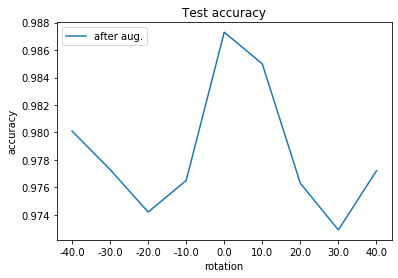

In [ ]:
#  Test "Accuracy" after rotation 
print(aug_rot_test_acc)

plt.plot(aug_rot_test_acc)

plt.title('Test accuracy')
plt.ylabel('accuracy')
plt.xlabel('rotation')
plt.legend(['after aug.'], loc = 'upper left')
plt.xticks(np.arange(len(degree_list)), degree_list)



plt.show()


[0.9866, 0.9751, 0.8609]


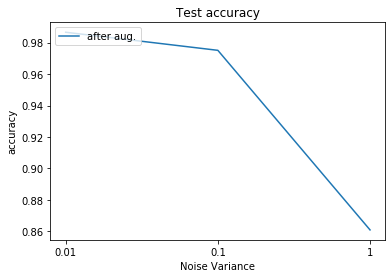

In [ ]:
#  Test "Accuracy" after noise 
print(aug_noi_test_acc)

plt.plot(aug_noi_test_acc)

plt.title('Test accuracy')
plt.ylabel('accuracy')
plt.xlabel('Noise Variance')
plt.legend(['after aug.'], loc='upper left')
plt.xticks(np.arange(len(var_list)), var_list)



plt.show()